In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import cv2 
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [5]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [6]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [7]:
annot = pd.read_csv('annotations.csv')
annot

,image,xmin,ymin,xmax,ymax,label
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc
...,...,...,...,...,...,...
2335,image-69.png,227.765502,207.710259,256.000000,248.054115,rbc
2336,image-69.png,201.832018,211.930101,251.736189,256.000000,rbc
2337,image-69.png,81.188275,231.883878,130.855693,254.391206,rbc
2338,image-69.png,35.903044,244.555806,79.863585,255.066516,rbc


In [8]:
annot['label'].value_counts()

rbc    2237
wbc     103
Name: label, dtype: int64

# Preparing the dataset

In [9]:
annot_rbc = annot[annot['label']=='rbc'].drop(['label'], axis=1)
annot_rbc

,image,xmin,ymin,xmax,ymax
0,image-100.png,0.000000,0.000000,25.190198,40.816803
1,image-100.png,15.010502,0.000000,68.337223,23.527421
2,image-100.png,25.017503,16.021004,78.374562,73.735123
3,image-100.png,75.565928,1.061844,140.248541,45.591599
4,image-100.png,77.483081,23.290548,131.936989,74.806301
...,...,...,...,...,...
2335,image-69.png,227.765502,207.710259,256.000000,248.054115
2336,image-69.png,201.832018,211.930101,251.736189,256.000000
2337,image-69.png,81.188275,231.883878,130.855693,254.391206
2338,image-69.png,35.903044,244.555806,79.863585,255.066516


In [10]:
annot_wbc = annot[annot['label']=='wbc'].drop(['label'], axis=1)
annot_wbc

,image,xmin,ymin,xmax,ymax
21,image-100.png,208.268378,191.901984,255.389732,253.438740
22,image-100.png,89.589265,148.633606,158.634772,221.078180
45,image-101.png,97.547258,105.493582,199.008168,216.887981
46,image-102.png,128.788798,135.189032,211.809802,219.912485
89,image-1.png,85.610268,2.334889,187.738623,120.068845
...,...,...,...,...,...
2209,image-35.png,83.875986,55.220970,185.833145,153.286359
2234,image-91.png,94.621195,146.192785,196.773393,240.510710
2259,image-7.png,28.599775,112.420519,116.317926,223.028185
2285,image-33.png,90.746336,135.036077,183.062007,228.898534


In [11]:
train_images=[]
train_labels=[]
for i in os.listdir('images'):
    try:
        if len(train_images)>600:
            break
        img = cv2.imread(os.path.join('images', i))
        trueVals=[]
     
        for row in annot_rbc.iterrows():
            if row[1][0] == i:
                x1 = int(row[1][1])
                y1 = int(row[1][2])
                x2 = int(row[1][3])
                y2 = int(row[1][4])
                trueVals.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
   
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for trueVal in trueVals:
                    x,y,w,h = result
                    iou = get_iou(trueVal,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    
                    if counter < 100:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1

                    
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue    
    

In [12]:
len(train_images)

614

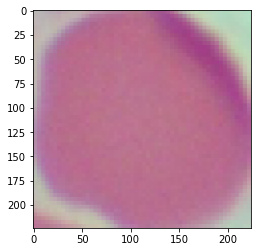

In [13]:

plt.imshow(cv2.cvtColor(train_images[23], cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
train_labels[10]

1

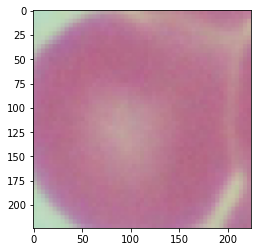

In [15]:

plt.imshow(cv2.cvtColor(train_images[101], cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
train_labels[101]

1

In [17]:
train_wbc=[]
label_wbc = []
for i in os.listdir('images'):
    try:
        if len(train_wbc)>800:
            break
        img = cv2.imread(os.path.join('images', i))
        trueVals=[]
     
        for row in annot_wbc.iterrows():
            if row[1][0] == i:
                x1 = int(row[1][1])
                y1 = int(row[1][2])
                x2 = int(row[1][3])
                y2 = int(row[1][4])
                trueVals.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            else:
                pass
            
        if len(trueVals): 
            ss.setBaseImage(img)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = img.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
        
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for trueVal in trueVals:
                        x,y,w,h = result
                        iou = get_iou(trueVal,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 120:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_wbc.append(resized)
                                label_wbc.append(0)
                                counter += 1

                    
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue    
    

In [18]:
len(train_wbc)

456

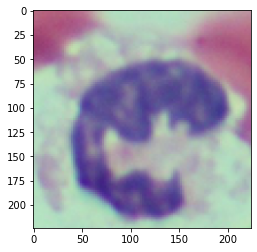

In [19]:
plt.imshow(cv2.cvtColor(train_wbc[17], cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
wbc_images = []
wbc_labels = []
for i in range(len(train_wbc)):
    if i%3 == 0:
        wbc_images.append(train_wbc[i])
        wbc_labels.append(label_wbc[i])

In [21]:
len(wbc_images)

152

In [22]:
final_images = np.array(train_images + wbc_images)
len(final_images)

766

In [23]:
final_labels = np.array(train_labels + wbc_labels)

In [24]:
len(final_labels)

766

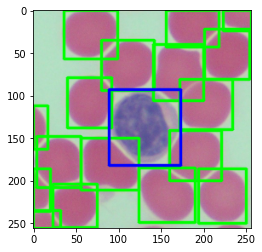

In [25]:
im = cv2.imread('images/image-4.png')
for row in annot_rbc.iterrows():
    if row[1][0]=='image-4.png':
            x1 = int(row[1][1])
            y1 = int(row[1][2])
            x2 = int(row[1][3])
            y2 = int(row[1][4])
            cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 2, cv2.LINE_AA)
            
for row in annot_wbc.iterrows():
    if row[1][0]=='image-4.png':
            x1 = int(row[1][1])
            y1 = int(row[1][2])
            x2 = int(row[1][3])
            y2 = int(row[1][4])
            cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 2, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

Above is the ground truth image

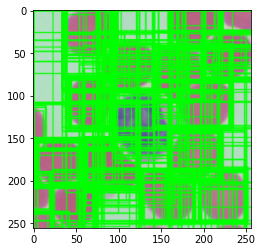

In [26]:
im = cv2.imread('images/image-4.png')
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

plt.imshow(cv2.cvtColor(imOut, cv2.COLOR_BGR2RGB))
plt.show()

Above is the output of Selective search 

# Model preparation

In [27]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [28]:
from tensorflow.keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

In [29]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [30]:
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(vggmodel.input,predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

C:\Users\shrish shrinath vaid\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Train-Test Split and One hot encoding

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(final_labels)
X_train, X_test , y_train, y_test = train_test_split(final_images,Y,test_size=0.10, random_state=23)

In [32]:
Y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

# Data Augmentation

In [33]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
trdata.fit(X_train)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
tsdata.fit(X_test)
testdata = tsdata.flow(x=X_test, y=y_test)

In [35]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Model training

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [37]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')


In [38]:
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto', restore_best_weights=True)


In [39]:
hist = model_final.fit_generator(traindata, steps_per_epoch= 1 , epochs= 50, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

C:\Users\shrish shrinath vaid\AppData\Local\Temp\ipykernel_19424\1281563816.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(traindata, steps_per_epoch= 1 , epochs= 50, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 0.8515 - accuracy: 0.4375
Epoch 1: val_loss improved from inf to 3.04621, saving model to ieeercnn_vgg16_1.h5
1/1 [==============================] - 45s 45s/step - loss: 0.8515 - accuracy: 0.4375 - val_loss: 3.0462 - val_accuracy: 0.7969
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 4.1760 - accuracy: 0.7188
Epoch 2: val_loss improved from 3.04621 to 0.32419, saving model to ieeercnn_vgg16_1.h5
1/1 [==============================] - 37s 37s/step - loss: 4.1760 - accuracy: 0.7188 - val_loss: 0.3242 - val_accuracy: 0.9531
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.8617 - accuracy: 0.9375
Epoch 3: val_loss improved from 0.32419 to 0.04918, saving model to ieeercnn_vgg16_1.h5
1/1 [==============================] - 34s 34s/step - loss: 0.8617 - accuracy: 0.9375 - val_loss: 0.0492 - val_accuracy: 0.9688
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.0414 - accur

1/1 [==============================] - 27s 27s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 31/50
1/1 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 31: val_loss did not improve from 0.00035
1/1 [==============================] - 27s 27s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 32/50
1/1 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000
Epoch 32: val_loss did not improve from 0.00035
1/1 [==============================] - 27s 27s/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 33/50
1/1 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 1.0000
Epoch 33: val_loss did not improve from 0.00035
1/1 [==============================] - 27s 27s/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 34/50
1/1 [==============================] - ETA: 0s - loss

# Testing

1/1 [==============================] - 0s 400ms/step
RBC
1/1 [==============================] - 0s 385ms/step
RBC
1/1 [==============================] - 0s 423ms/step
RBC
1/1 [==============================] - 0s 401ms/step
RBC
1/1 [==============================] - 0s 385ms/step
RBC
1/1 [==============================] - 0s 411ms/step
RBC
1/1 [==============================] - 0s 428ms/step
RBC
1/1 [==============================] - 0s 425ms/step
RBC
1/1 [==============================] - 0s 414ms/step
RBC
1/1 [==============================] - 0s 398ms/step
RBC
1/1 [==============================] - 0s 405ms/step
RBC
1/1 [==============================] - 0s 385ms/step
RBC
1/1 [==============================] - 0s 451ms/step
RBC
1/1 [==============================] - 0s 392ms/step
RBC
1/1 [==============================] - 0s 400ms/step
RBC
1/1 [==============================] - 0s 410ms/step
RBC
1/1 [==============================] - 0s 410ms/step
RBC
1/1 [==========================

1/1 [==============================] - 0s 384ms/step
RBC
1/1 [==============================] - 0s 355ms/step
RBC
1/1 [==============================] - 0s 449ms/step
RBC
1/1 [==============================] - 0s 384ms/step
RBC
1/1 [==============================] - 0s 422ms/step
RBC
1/1 [==============================] - 0s 383ms/step
RBC
1/1 [==============================] - 0s 390ms/step
RBC
1/1 [==============================] - 0s 405ms/step
RBC
1/1 [==============================] - 0s 402ms/step
RBC
1/1 [==============================] - 0s 422ms/step
RBC
1/1 [==============================] - 0s 375ms/step
RBC
1/1 [==============================] - 0s 374ms/step
RBC
1/1 [==============================] - 0s 410ms/step
RBC
1/1 [==============================] - 0s 411ms/step
RBC
1/1 [==============================] - 0s 400ms/step
RBC
1/1 [==============================] - 0s 408ms/step
RBC
1/1 [==============================] - 0s 400ms/step


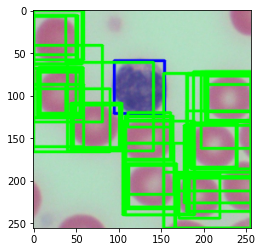

In [66]:

img = cv2.imread('images/image-82.png')
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 250:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
#         print(out[0])
        if out[0][0] > 0.99999:
            print("RBC")
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 2, cv2.LINE_AA)
        if out[0][1] > 0.9999:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 2, cv2.LINE_AA)


In [73]:
im = cv2.imread('images/image-82.png')
for row in annot_rbc.iterrows():
    if row[1][0]=='image-82.png':
            x1 = int(row[1][1])
            y1 = int(row[1][2])
            x2 = int(row[1][3])
            y2 = int(row[1][4])
            cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 2, cv2.LINE_AA)
            
for row in annot_wbc.iterrows():
    if row[1][0]=='image-82.png':
            x1 = int(row[1][1])
            y1 = int(row[1][2])
            x2 = int(row[1][3])
            y2 = int(row[1][4])
            cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 2, cv2.LINE_AA)

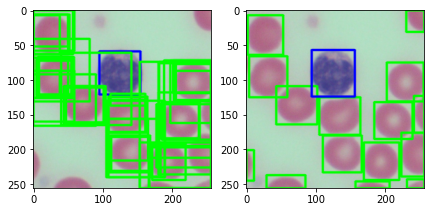

In [74]:

f, axes = plt.subplots(1,2, figsize=(7,7))
axes[0].imshow(cv2.cvtColor(imout, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In above Plot, the model predicted output(on left) and ground truth values(on right) is shown. 

# Loading the Model

In [43]:
from tensorflow.keras.models import load_model

In [41]:
# model.save('gfgModel.h5')
# print('Model Saved!')

In [44]:
savedModel=load_model('ieeercnn_vgg16_1.h5')
savedModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     